In [2]:
import torch
from torch.utils import data
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# 여기서부턴 내가 추가한 import
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [4]:
# CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cpu')

### 파라미터 설정

In [19]:
batch_size = 100
learning_rate = 0.0001
epoch_num = 15

### 데이터준비

In [31]:
train_data = datasets.MNIST(
    root = "./data/",
    train = True,
    download = True,
    transform = transforms.ToTensor())
test_data = datasets.MNIST(
    root = "./data/",
    train = False,
    download = True,
    transform = transforms.ToTensor())

In [34]:
# 총 데이터 개수
len(train_data), len(test_data)

(60000, 10000)

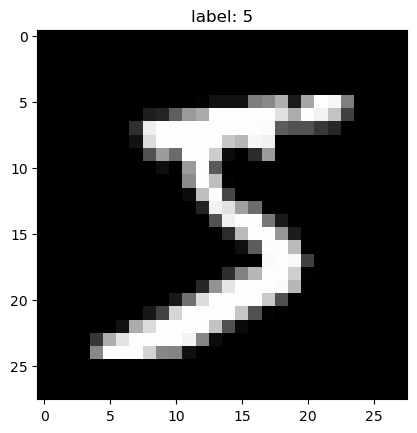

In [36]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap ='gray')
plt.title('label: %s' % label)
plt.show()

#### 미니배치구성

In [37]:
# 데이터를 데이터로더에 전달
trian_loader = torch.utils.data.DataLoader(dataset = train_data,
                                          batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                         batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()

In [46]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding = 'same')
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 'same')
        self.dropout = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(3136, 1000) # 7*7*64=3436
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.dropout(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [47]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterison = nn.CrossEntropyLoss()

In [48]:
model.train()
i = 1
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterison(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('train step: {}\t loss: {:.3f}'.format(i, loss.item()))
            
        i += 1

train step: 1000	 loss: 0.213
train step: 2000	 loss: 0.069
train step: 3000	 loss: 0.119
train step: 4000	 loss: 0.034
train step: 5000	 loss: 0.030
train step: 6000	 loss: 0.033
train step: 7000	 loss: 0.119
train step: 8000	 loss: 0.017
train step: 9000	 loss: 0.007


- train step 별 loss값

In [49]:
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()
    
print('test set : accuracy:{:.2f}%'.format(100. * correct / len(test_loader.dataset)))

test set : accuracy:99.14%


- test 정확도